In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from d2l import torch as d2l
import time
from sklearn.metrics import f1_score
from torch.nn import functional as F
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [2]:
path = "F:/Document/France/ENPC/Cours/S5/Projet/data/"
os.chdir(path)

In [ ]:
# df_data = pd.read_csv("alldata.csv", header=0)
# df_data = df_data.dropna()
# df_data = df_data.drop(df_data[df_data['Exploitable'] == 0].index)

# list_vitesse = []
# for i in df_data['Vitesse']:
#     list_vitesse.append(eval(i))

# list_frf_reel = []
# for i in df_data['FRF réel']:
#     list_frf_reel.append(eval(i))

# list_frf_imag = []
# for i in df_data['FRF imag']:
#     list_frf_imag.append(eval(i))

# list_fft = []
# for i in df_data['Y Fourier']:
#     list_fft.append(eval(i))

# np_vitesse = np.array(list_vitesse)
# np_frf_reel = np.array(list_frf_reel)
# np_frf_imag = np.array(list_frf_imag)
# np_frf = np.sqrt(np.square(np_frf_reel) + np.square(np_frf_imag))
# np_fft = np.array(list_fft)
# np_classe = df_data['Niveau'].values
# np_classe = pd.get_dummies(np_classe).values

# np_data = np.concatenate((np_vitesse, np_frf, np_fft, np_classe), axis=1)
# df_data_done = pd.DataFrame(np_data)
# df_data_done.to_csv('datadone.csv', header=False, index=False)

In [3]:
df_data = pd.read_csv("datadone.csv", header=None)
np_data = df_data.values
np.random.shuffle(np_data)

In [4]:
np_vitesse = np_data[:, :614]
np_frf = np_data[:, 614:1228]
np_fft = np_data[:, 1228:1535]
np_classe = np_data[:, 1535:]

In [5]:
ts_vitesse = torch.tensor(np_vitesse, dtype=torch.float32).reshape(np_vitesse.shape[0], 1, np_vitesse.shape[1])
ts_frf = torch.tensor(np_frf, dtype=torch.float32).reshape(np_frf.shape[0], 1, np_frf.shape[1])
ts_fft = torch.tensor(np_fft, dtype=torch.float32).reshape(np_fft.shape[0], 1, np_fft.shape[1])
ts_classe = torch.tensor(np_classe, dtype=torch.float32)
ts_feature = torch.concat((ts_vitesse, ts_frf), dim=1)

In [6]:
threshold1 = int(0.6*ts_feature.shape[0])
threshold2 = int(0.8*ts_feature.shape[0])
X_train_v = ts_vitesse[:threshold1]
X_train_f = ts_frf[:threshold1]
X_train_fft = ts_fft[:threshold1]
X_train = ts_feature[:threshold1]
Y_train = ts_classe[:threshold1]
X_valid_v = ts_vitesse[threshold1:threshold2]
X_valid_f = ts_frf[threshold1:threshold2]
X_valid_fft = ts_fft[threshold1:threshold2]
X_valid = ts_feature[threshold1:threshold2]
Y_valid = ts_classe[threshold1:threshold2]
X_test_v = ts_vitesse[threshold2:]
X_test_f = ts_frf[threshold2:]
X_test_fft = ts_fft[threshold2:]
X_test = ts_feature[threshold2:]
Y_test = ts_classe[threshold2:]

In [7]:
lenet_v = nn.Sequential(
              nn.Conv1d(1, 6, kernel_size=5, stride=2,
                        padding=2), nn.ReLU(),
              nn.MaxPool1d(kernel_size=2, stride=2),
              nn.Conv1d(6, 16, kernel_size=5,
                        padding=2), nn.ReLU(),
              nn.MaxPool1d(kernel_size=2, stride=2),
              nn.Flatten(),
              nn.Linear(1216, 120), nn.ReLU(),
              nn.Linear(120, 84), nn.ReLU(),
              nn.Linear(84, 5))

In [8]:
lenet_f = nn.Sequential(
              nn.Conv1d(1, 6, kernel_size=5, stride=2,
                        padding=2), nn.ReLU(),
              nn.MaxPool1d(kernel_size=2, stride=2),
              nn.Conv1d(6, 16, kernel_size=5,
                        padding=2), nn.ReLU(),
              nn.MaxPool1d(kernel_size=2, stride=2),
              nn.Flatten(),
              nn.Linear(1216, 120), nn.ReLU(),
              nn.Linear(120, 84), nn.ReLU(),
              nn.Linear(84, 5))

In [9]:
lenet_fft = nn.Sequential(
              nn.Conv1d(1, 6, kernel_size=5, stride=2,
                        padding=2), nn.ReLU(),
              nn.MaxPool1d(kernel_size=2, stride=2),
              nn.Conv1d(6, 16, kernel_size=5,
                        padding=2), nn.ReLU(),
              nn.MaxPool1d(kernel_size=2, stride=2),
              nn.Flatten(),
              nn.Linear(608, 120), nn.ReLU(),
              nn.Linear(120, 84), nn.ReLU(),
              nn.Linear(84, 5))

In [10]:
lenet = nn.Sequential(
            nn.Conv1d(2, 6, kernel_size=5, stride=2,
                    padding=2), nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(6, 16, kernel_size=5,
                    padding=2), nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(1216, 120), nn.ReLU(),
            nn.Linear(120, 84), nn.ReLU(),
            nn.Linear(84, 5))

In [41]:
class Residual1d(nn.Module):
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv1d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv1d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv1d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm1d(num_channels)
        self.bn2 = nn.BatchNorm1d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))  # conv1 +batchnorm + relu
        Y = self.bn2(self.conv2(Y))  # conv2 + batchnorm
        if self.conv3:
            X = self.conv3(X)
        Y += X   # residual + base
        return F.relu(Y)

def resnet_block1d(input_channels, num_channels, num_residuals,
                   first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual1d(input_channels, num_channels,
                                  use_1x1conv=True, strides=2))
        else:
            blk.append(Residual1d(num_channels, num_channels))
    return blk

# stage1, length / 2
b1 = nn.Sequential(nn.Conv1d(2, 16, kernel_size=7, stride=2, padding=3),
                    nn.BatchNorm1d(16), nn.ReLU(),
                    nn.MaxPool1d(kernel_size=3, stride=2, padding=1))
# stage2, keep form
b2 = nn.Sequential(*resnet_block1d(16, 16, 2, first_block=True))
# stage3, channel * 2
b3 = nn.Sequential(*resnet_block1d(16, 32, 2))
# stage4, channel * 2, length / 2
b4 = nn.Sequential(*resnet_block1d(32, 64, 2))
b5 = nn.Sequential(*resnet_block1d(64, 128, 2))
resnet = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool1d((1)),
                    nn.Flatten(), nn.Linear(128, 5))

In [42]:
b1_f = nn.Sequential(nn.Conv1d(1, 16, kernel_size=7, stride=2, padding=3),
                    nn.BatchNorm1d(16), nn.ReLU(),
                    nn.MaxPool1d(kernel_size=3, stride=2, padding=1))
b2_f = nn.Sequential(*resnet_block1d(16, 16, 2, first_block=True))
b3_f = nn.Sequential(*resnet_block1d(16, 32, 2))
b4_f = nn.Sequential(*resnet_block1d(32, 64, 2))
b5_f = nn.Sequential(*resnet_block1d(64, 128, 2))
resnet_f = nn.Sequential(b1_f, b2_f, b3_f, b4_f, b5_f,
                    nn.AdaptiveAvgPool1d((1)),
                    nn.Flatten(), nn.Linear(128, 5))



In [43]:
b1_fft = nn.Sequential(nn.Conv1d(1, 16, kernel_size=7, stride=2, padding=3),
                    nn.BatchNorm1d(16), nn.ReLU(),
                    nn.MaxPool1d(kernel_size=3, stride=2, padding=1))
b2_fft = nn.Sequential(*resnet_block1d(16, 16, 2, first_block=True))
b3_fft = nn.Sequential(*resnet_block1d(16, 32, 2))
b4_fft = nn.Sequential(*resnet_block1d(32, 64, 2))
b5_fft = nn.Sequential(*resnet_block1d(64, 128, 2))
resnet_fft = nn.Sequential(b1_fft, b2_fft, b3_fft, b4_fft, b5_fft,
                    nn.AdaptiveAvgPool1d((1)),
                    nn.Flatten(), nn.Linear(128, 5))

In [13]:
def try_gpu(i=0):
    """if gpu exist, return gpu(i), otherwise, return cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [14]:
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    y = y.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [15]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    if not device: 
        device = try_gpu()
    metric = d2l.Accumulator(2) 
    for X, y in data_iter:
        X, y = X.to(device), y.to(device)
        metric.add(accuracy(net(X), y), y.shape[0])
    return metric[0] / metric[1]

In [16]:
def train_accuracy(net, X_train, Y_train, X_valid, Y_valid, num_epochs, lr, weight_decay, batch_size, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    train_iter = d2l.load_array((X_train, Y_train), batch_size)
    test_iter = d2l.load_array((X_valid, Y_valid), batch_size,
                               is_train=False)
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

In [17]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
num_epochs, lr, weight_decay, batch_size, device = 20, 1e-3, 0, 64, try_gpu()

loss 0.331, train acc 0.865, test acc 0.852
1759.9 examples/sec on cuda:0


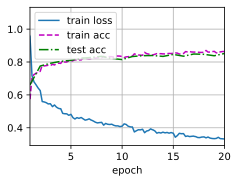

In [18]:
train_accuracy(lenet_v, X_train_v, Y_train, X_valid_v, Y_valid, num_epochs, lr, weight_decay, batch_size, device)

In [19]:
torch.save(lenet_v, "./lenet_v.pkl")

loss 0.118, train acc 0.954, test acc 0.926
9123.2 examples/sec on cuda:0


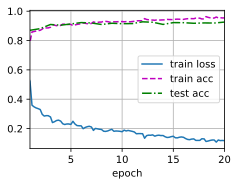

In [20]:
train_accuracy(lenet_f, X_train_f, Y_train, X_valid_f, Y_valid, num_epochs, lr, weight_decay, batch_size, device)

In [21]:
torch.save(lenet_f, "./lenet_f.pkl")

loss 0.133, train acc 0.947, test acc 0.911
9218.8 examples/sec on cuda:0


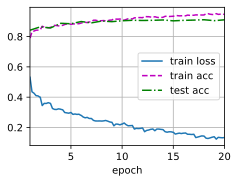

In [22]:
train_accuracy(lenet_fft, X_train_fft, Y_train, X_valid_fft, Y_valid, num_epochs, lr, weight_decay, batch_size, device)

In [23]:
torch.save(lenet_fft, "./lenet_fft.pkl")

loss 0.139, train acc 0.944, test acc 0.916
9672.7 examples/sec on cuda:0


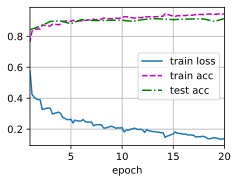

In [24]:
train_accuracy(lenet, X_train, Y_train, X_valid, Y_valid, num_epochs, lr, weight_decay, batch_size, device)

In [25]:
torch.save(lenet, "./lenet.pkl")

loss 0.084, train acc 0.967, test acc 0.928
1737.6 examples/sec on cuda:0


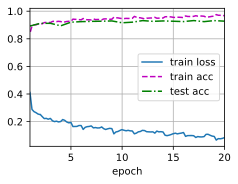

In [44]:
train_accuracy(resnet, X_train, Y_train, X_valid, Y_valid, num_epochs, lr, weight_decay, batch_size, device)

In [45]:
torch.save(resnet, "./resnet.pkl")

loss 0.086, train acc 0.967, test acc 0.931
1794.9 examples/sec on cuda:0


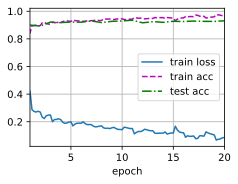

In [46]:
train_accuracy(resnet_f, X_train_f, Y_train, X_valid_f, Y_valid, num_epochs, lr, weight_decay, batch_size, device)

In [47]:
torch.save(resnet_f, "./resnet_f.pkl")

loss 0.063, train acc 0.976, test acc 0.918
1734.4 examples/sec on cuda:0


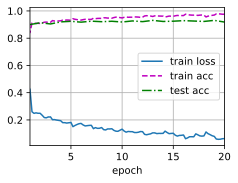

In [48]:
train_accuracy(resnet_fft, X_train_fft, Y_train, X_valid_fft, Y_valid, num_epochs, lr, weight_decay, batch_size, device)

In [49]:
torch.save(resnet_fft, "./resnet_fft.pkl")

In [50]:
def plot_confusion_matrix(cm):
    df_cm = pd.DataFrame(cm / np.sum(cm, axis=1).reshape(-1, 1), range(5), range(5))
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True)
    plt.show()

In [51]:
def evaluate_net(net, X_test, Y_test):
    net.cpu()
    Y_pred = net(X_test)
    np_Y_pred = Y_pred.argmax(axis=1).numpy()
    np_Y_test = Y_test.argmax(axis=1).numpy()
    f1s = f1_score(np_Y_test, np_Y_pred, average='weighted')
    print(f'F1 score: {f1s:.3f}')
    cm = confusion_matrix(np_Y_test, np_Y_pred)
    plot_confusion_matrix(cm)


F1 score: 0.911


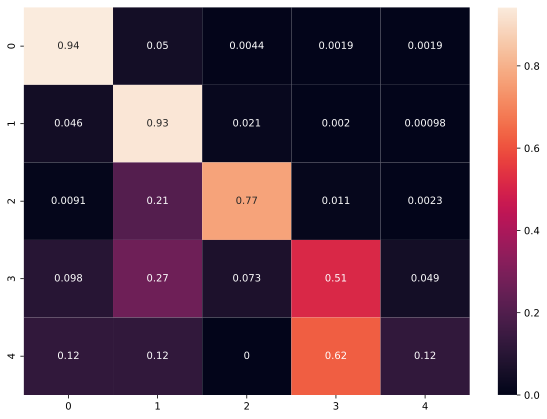

In [52]:
evaluate_net(lenet, X_test, Y_test)

F1 score: 0.837


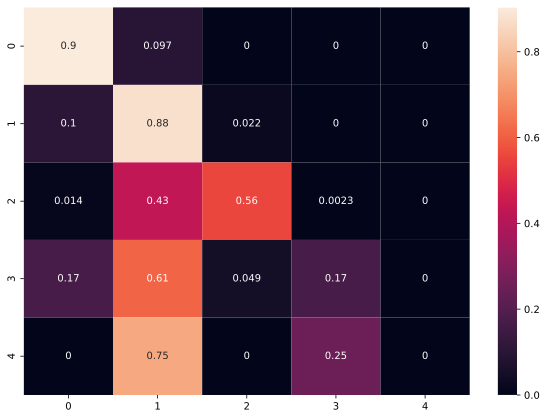

In [53]:
evaluate_net(lenet_v, X_test_v, Y_test)

F1 score: 0.918


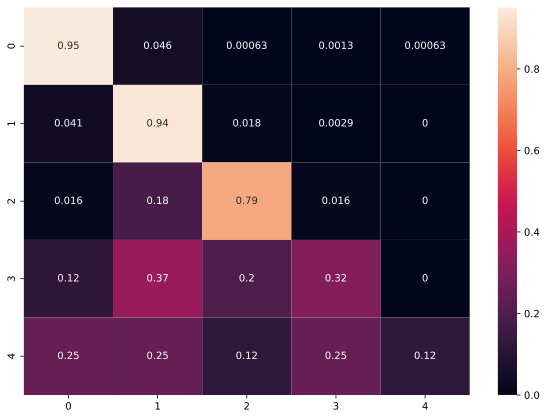

In [54]:
evaluate_net(lenet_f, X_test_f, Y_test)

F1 score: 0.907


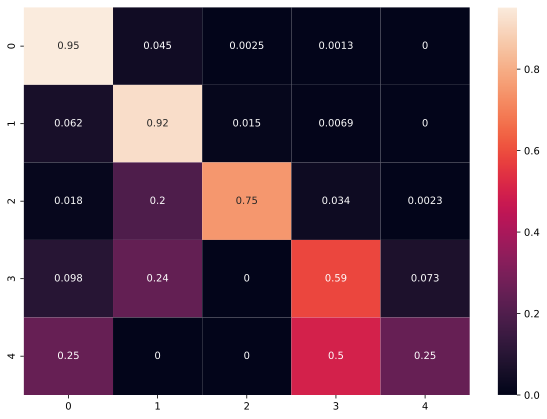

In [55]:
evaluate_net(lenet_fft, X_test_fft, Y_test)

F1 score: 0.921


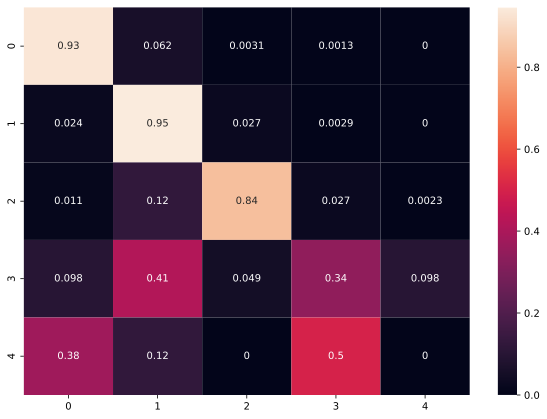

In [56]:
evaluate_net(resnet, X_test, Y_test)

F1 score: 0.926


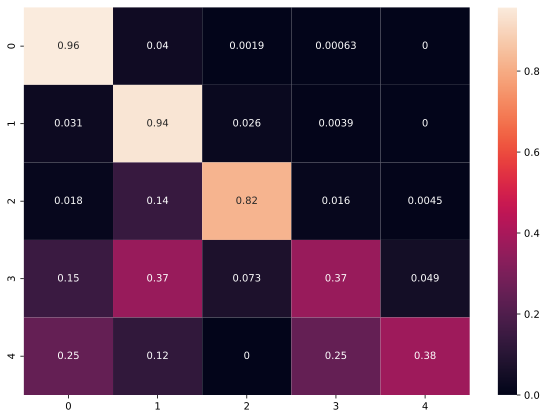

In [57]:
evaluate_net(resnet_f, X_test_f, Y_test)

F1 score: 0.915


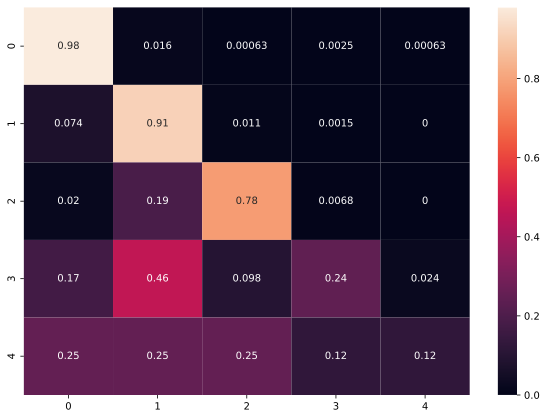

In [58]:
evaluate_net(resnet_fft, X_test_fft, Y_test)